## Build a model using Keras

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests


In [0]:
### Download data from google drive. You need not mess with this code.

import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
if __name__ == "__main__":
    file_id = '1DHF4b0sBB_KLQ4oxNEMp0sGrViu0gpeG'
    destination = 'data.csv'
    download_file_from_google_drive(file_id, destination)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests


# Importing and cleaning data using pandas library
data = pd.read_csv('data.csv')

## Last column is output features. Rest are inputs
X = data.iloc[:, 1:-1].values

# 2nd column is output labels
y = data.iloc[:, -1].values

Convert labels to intermediate representation where each label is replaced by a number from 0 to Ny-1
(Ny is number of classes)

In [0]:
def conv_labels(y_raw):
    """
    Inputs:
        y_raw: numpy array of labels
    Outputs:
        y: numpy array of ints, each label is replaced by an int from 0 to Ny-1
        Ny: number of classes
    """
    # YOUR CODE HERE
    d={}
    cnt=0
    for i in y_raw:
      if i not in d.keys():
        d[i]=cnt
        cnt+=1
    for i in range(len(y_raw)):
      y_raw[i]=d[y_raw[i]]
    return y_raw

In [18]:
y_raw=np.array(["h1", "h2", "h3", "h4"])
conv_labels(y_raw)

array(['0', '1', '2', '3'], dtype='<U2')

In [0]:
### One-hot encode Y_v
def oneHot(y, Ny):
    '''
    Input:
        y: an int in {0, 1}
        Ny: Number of classes, e.g., 2 here.
    Output:
        Y: a vector of Ny (=2) tuples
    '''
    # YOUR CODE HERE
    from keras.utils import to_categorical
    return to_categorical(y,num_classes=Ny)

In [0]:
"""Test for one-hot"""
assert np.all(oneHot(0,3)==np.array([1,0,0]))



#### Create Y_o which is one-hot encoding of Y using above functions


In [0]:
def create_Y_o(y):
    """
    Inputs:
        y: numpy array of class labels
    Outputs:
        Y_o: numpy array of shape(samples, Ny) with one-hot encodings of y
        Ny: number of unique classes
    """
    # YOUR CODE HERE
    lab_e=conv_labels(y)
    Ny=len(set(y))
    Y_o=oneHot(y,Ny)
    return Y_o, Ny

Y_o, Ny = create_Y_o(y)


In [0]:
### Split data into train and test. Keep 10% of samples for testing
## Divide the data into these variables - X_train, X_test, y_train, y_test
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,Y_o,test_size=0.1,random_state=42)

In [0]:
"""test for splitting"""
assert(X_train.shape[0] == 13608)

In [0]:
## Normalize the Data
def findMeanStddev(X):
    '''
    Input: 
        X: a matrix of size (no. of samples, dimension of each sample)
    Output:
        mean: mean of samples in X (same size as X)
        stddev: element-wise std dev of sample in X (same size as X)
    '''
    # YOUR CODE HERE
    X=np.array(X)
    meanx=X.mean(axis=0)
    stddevx=X.std(axis=0)
    return meanx,stddevx
    

In [0]:
def normalizeX(X, mean, stddev):
    '''
    Input:
        X: a matrix of size (no. of samples, dimension of each sample)
        mean: mean of samples in X (same size as X)
        stddev: element-wise std dev of sample in X (same size as X) 
    Output:
        Xn: X modified to have 0 mean and 1 std dev
    '''
    # YOUR CODE HERE
    stddev+=10**(-19)
    Xn=[]
    for ele in X:
      Xn.append((ele-mean)/stddev)
    return np.array(Xn)
      

mean_train, stddev_train = findMeanStddev(X_train)
X_train = normalizeX(X_train, mean_train, stddev_train)
X_test = normalizeX(X_test, mean_train, stddev_train)

#### Create model. 
- Choose the number of hidden layers, neurons, activations, loss function, learning rate and optimizers on your own.
- Report accuracy metric
- Use no more than 100 epochs
- Use validation_split = 0.1

In [0]:
import keras
def create_model():
    """
    Inputs:
        None
    Outputs:
        model: keras model afteer compiling
    """
    # YOUR CODE HERE
    from keras.layers import Input,Dense
    input_layer=Input(shape = X_train.shape[1:])
    hidden_layer = Dense(256, activation = 'sigmoid',)(input_layer)
    hidden_layer2 = Dense(128, activation = 'sigmoid',)(hidden_layer)
#     hidden_layer3 = Dense(64, activation = 'sigmoid',)(hidden_layer2)
    output_layer = Dense(Ny, activation = 'softmax')(hidden_layer2)

    from keras.models import Model
    from keras import optimizers
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer=optimizers.adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [189]:
model = create_model()
history = model.fit(X_train, y_train, epochs=100, batch_size = 100, validation_split = 0.1)

Train on 12247 samples, validate on 1361 samples
Epoch 1/100
12247/12247 [==============================] - 2s 190us/step - loss: 1.0032 - acc: 0.5780 - val_loss: 0.7970 - val_acc: 0.6738
Epoch 2/100
12247/12247 [==============================] - 0s 35us/step - loss: 0.7338 - acc: 0.6853 - val_loss: 0.6958 - val_acc: 0.7061
Epoch 3/100
12247/12247 [==============================] - 0s 34us/step - loss: 0.6714 - acc: 0.7136 - val_loss: 0.6632 - val_acc: 0.7340
Epoch 4/100
12247/12247 [==============================] - 0s 35us/step - loss: 0.6271 - acc: 0.7303 - val_loss: 0.6359 - val_acc: 0.7259
Epoch 5/100
12247/12247 [==============================] - 0s 38us/step - loss: 0.5944 - acc: 0.7480 - val_loss: 0.6130 - val_acc: 0.7303
Epoch 6/100
12247/12247 [==============================] - 0s 36us/step - loss: 0.5709 - acc: 0.7555 - val_loss: 0.5732 - val_acc: 0.7568
Epoch 7/100
12247/12247 [==============================] - 0s 35us/step - loss: 0.5414 - acc: 0.7684 - val_loss: 0.5526 - 

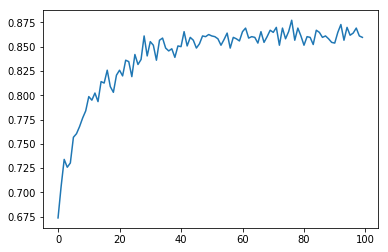

In [190]:
from matplotlib import pyplot as plt
plt.plot(history.history['val_acc'])

#### Evalutaion


In [0]:
"""Test for model"""
Y_pred = model.predict(X_test)

In [198]:
"""Test for model"""


'Test for model'

In [199]:
"""Test for model"""


'Test for model'

#### Confusion Matrix

In [200]:
def create_cm(Y_test, Y_pred):
    """
    Inputs:
        Y_test: numpy array with true labels
        Y_pred: numpy array with predicted labels
    Outputs:
        CM: numpy array (ndim=2) containing confusion matrix
    """
    # YOUR CODE HERE
    from sklearn.metrics import confusion_matrix
    CM = confusion_matrix(y_test.argmax(axis=1), Y_pred.argmax(axis=1))
    loss, accuracy = model.evaluate(X_test, Y_test,verbose=0)  # Evaluate the model
    print('Accuracy :',accuracy)
    print(CM)
    return CM
cm=create_cm(y_test,Y_pred)

Accuracy : 0.8544973544973545
[[192   5   0   0   4   2   0]
 [ 17 155  32   0   6   0   0]
 [  6  46 163  12   0   0   0]
 [  0   0   7 217   0   0   0]
 [  1   3   0   0 206  23   4]
 [  3   0   0   0  35 166   3]
 [  0   0   0   0   5   6 193]]


In [201]:
"""Test for confusion matrix"""

'Test for confusion matrix'

In [202]:
def precision(cm, cls):
    """
    Inputs:
        cm: numpy array of shape (Ny, Ny) containing confusion matrix
        cls: class for which precision has to be computed
    Outputs:
        prec: precision for class cls 
    """
    # YOUR CODE HERE
    s=sum
    precision = cm[cls,cls]/np.sum(cm,axis=0)[cls]
    return precision
precision(cm, 6)

0.965